# Introduction to hypothesis testing
You now know how to define and estimate parameters given a model. But the question remains: how reasonable is it to observe your data if a model is true? This question is addressed by hypothesis tests. They are the icing on the inference cake. After completing this chapter, you will be able to carefully construct and test hypotheses using hacker statistics.

# 1. Formulating and simulating a hypothesis
## 1.1 Generating a permutation sample
In the video, you learned that permutation sampling is a great way to simulate the hypothesis that two variables have identical probability distributions. This is often a hypothesis you want to test, so in this exercise, you will write a function to generate a permutation sample from two data sets.

Remember, a permutation sample of two arrays having respectively `n1` and `n2` entries is constructed by concatenating the arrays together, scrambling the contents of the concatenated array, and then taking the first `n1` entries as the permutation sample of the first array and the last `n2` entries as the permutation sample of the second array.

### Instructions:
* Concatenate the two input arrays into one using `np.concatenate()`. Be sure to pass in `data1` and `data2` as one argument `(data1, data2)`.
* Use `np.random.permutation()` to permute the concatenated array.
* Store the first `len(data1)` entries of `permuted_data` as `perm_sample_1` and the last `len(data2)` entries of `permuted_data` as `perm_sample_2`. In practice, this can be achieved by using `:len(data1)` and `len(data1):` to slice `permuted_data`.
* Return `perm_sample_1` and `perm_sample_2`.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def ecdf(data):
    return np.sort(data), np.arange(1, len(data)+1) / len(data)

def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    return np.array([bootstrap_replicate_1d(data, func) for _ in range(size)])

np.random.seed(42)

In [2]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

## 1.2 Visualizing permutation sampling
To help see how permutation sampling works, in this exercise you will generate permutation samples and look at them graphically.

We will use the Sheffield Weather Station data again, this time considering the monthly rainfall in July (a dry month) and November (a wet month). We expect these might be differently distributed, so we will take permutation samples to see how their ECDFs _would look if_ they were identically distributed.

The data are stored in the Numpy arrays `rain_june` and `rain_november`.

As a reminder, `permutation_sample()` has a function signature of `permutation_sample(data_1, data_2)` with a return value of `permuted_data[:len(data_1)]`, `permuted_data[len(data_1):]`, where `permuted_data = np.random.permutation(np.concatenate((data_1, data_2)))`.

### Instructions:
* Write a for loop to `50` generate permutation samples, compute their ECDFs, and plot them.
    * Generate a permutation sample pair from `rain_june` and `rain_november` using your `permutation_sample()` function.
    * Generate the `x` and `y` values for an ECDF for each of the two permutation samples for the ECDF using your `ecdf()` function.
    * Plot the ECDF of the first permutation sample (`x_1` and `y_1`) as dots. Do the same for the second permutation sample (`x_2` and `y_2`).
* Generate `x` and `y` values for ECDFs for the `rain_june` and `rain_november` data and plot the ECDFs using respectively the keyword arguments `color='red'` and `color='blue'`.
* Label your axes, set a 2% margin, and show your plot. This has been done for you, so just hit 'Submit Answer' to view the plot!

In [3]:
# Loading dataset and definition of rain_june and rain_november
df = pd.read_csv('_datasets/sheffield_weather_station.csv',
            comment='#', delimiter='\s+', na_values='---')
df = df[df.yyyy <= 2015]
rain_june = df.loc[df.mm==6, 'rain'].values
rain_november = df.loc[df.mm==11, 'rain'].values

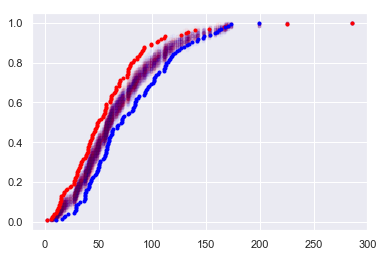

In [4]:
for i in range(50):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(rain_june, rain_november)


    # Compute ECDFs
    x_1, y_1 = ecdf(perm_sample_1)
    x_2, y_2 = ecdf(perm_sample_2)

    # Plot ECDFs of permutation sample
    _ = plt.plot(x_1, y_1, marker='.', linestyle='none',
                 color='red', alpha=0.02)
    _ = plt.plot(x_2, y_2, marker='.', linestyle='none',
                 color='blue', alpha=0.02)

# Create and plot ECDFs from original data
x_1, y_1 = ecdf(rain_june)
x_2, y_2 = ecdf(rain_november)
_ = plt.plot(x_1, y_1, marker='.', linestyle='none', color='red')
_ = plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue')

Notice that the permutation samples ECDFs overlap and give a purple haze. None of the ECDFs from the permutation samples overlap with the observed data, suggesting that the hypothesis is not commensurate with the data. July and November rainfall are not identically distributed.

# 2. Test statistics and p-values
#### Test statistics
When performing hypothesis tests, your choice of test statistic should be:
* be pertinent to the question you are seeking to answer in your hypothesis test.

#### What is a p-value?
The p-value is generally a measure of:
* the probability of observing a test statistic equally or more extreme than the one you observed, given that the null hypothesis is true.

## 2.1 Generating permutation replicates
As discussed in the video, a permutation replicate is a single value of a statistic computed from a permutation sample. As the `draw_bs_reps()` function you wrote in chapter 2 is useful for you to generate bootstrap replicates, it is useful to have a similar function, `draw_perm_reps()`, to generate permutation replicates. You will write this useful function in this exercise.

The function has call signature `draw_perm_reps(data_1, data_2, func, size=1)`. Importantly, `func` must be a function that takes two arrays as arguments. In most circumstances, `func` will be a function you write yourself.

### Instructions:
* Define a function with this signature: `draw_perm_reps(data_1, data_2, func, size=1)`.
    * Initialize an array to hold the permutation replicates using `np.empty()`.
    * Write a `for` loop to:
        * Compute a permutation sample using your `permutation_sample()` function
        * Pass the samples into `func()` to compute the replicate and store the result in your array of replicates.
    * Return the array of replicates.

In [5]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

## 2.2 Look before you leap: EDA before hypothesis testing
Kleinteich and Gorb (_Sci. Rep._, __4__, 5225, 2014) performed an interesting experiment with South American horned frogs. They held a plate connected to a force transducer, along with a bait fly, in front of them. They then measured the impact force and adhesive force of the frog's tongue when it struck the target.

Frog A is an adult and Frog B is a juvenile. The researchers measured the impact force of 20 strikes for each frog. In the next exercise, we will test the hypothesis that the two frogs have the same distribution of impact forces. But, remember, it is important to do EDA first! Let's make a bee swarm plot for the data. They are stored in a Pandas data frame, `df`, where column `ID` is the identity of the frog and column `impact_force` is the impact force in Newtons (N).

### Instructions:
* Use `sns.swarmplot()` to make a bee swarm plot of the data by specifying the `x`, `y`, and `data` keyword arguments.
* Label your axes.
* Show the plot.

In [6]:
# Load frog_tongue dataset
df = pd.read_csv('_datasets/frog_tongue.csv', comment='#')
df = df.loc[df['ID'].isin(['II', 'IV']), ['ID', 'impact force (mN)']]
df.ID = df.ID.map(lambda x: 'A' if x=='II' else 'B')
df = df.rename(columns={'impact force (mN)': 'impact_force'})
df.impact_force /= 1000

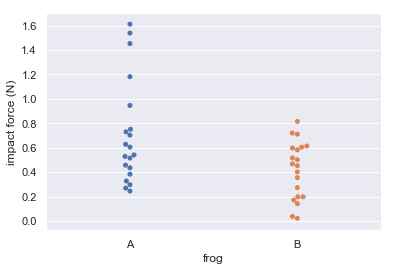

In [7]:
# Make bee swarm plot
_ = sns.swarmplot(x='ID', y='impact_force', data=df)

# Label axes
_ = plt.xlabel('frog')
_ = plt.ylabel('impact force (N)')

# Show the plot
plt.show()

Eyeballing it, it does not look like they come from the same distribution. Frog A, the adult, has three or four very hard strikes, and Frog B, the juvenile, has a couple weak ones. However, it is possible that with only 20 samples it might be too difficult to tell if they have difference distributions, so we should proceed with the hypothesis test.

## 2.3 Permutation test on frog data
The average strike force of Frog A was 0.71 Newtons (N), and that of Frog B was 0.42 N for a difference of 0.29 N. It is possible the frogs strike with the same force and this observed difference was by chance. You will compute the probability of getting at least a 0.29 N difference in mean strike force under the hypothesis that the distributions of strike forces for the two frogs are identical. We use a permutation test with a test statistic of the difference of means to test this hypothesis.

For your convenience, the data has been stored in the arrays `force_a` and `force_b`.

### Instructions:
* Define a function with call signature `diff_of_means(data_1, data_2)` that returns the differences in means between two data sets, mean of `data_1` minus mean of `data_2`.
* Use this function to compute the empirical difference of means that was observed in the frogs.
* Draw 10,000 permutation replicates of the difference of means.
* Compute the p-value.
* Print the p-value.

In [8]:
# Reload frog_tongue dataset and specify force_a and force_b
df = pd.read_csv('_datasets/frog_tongue.csv', comment='#')
force_a = df.loc[df['ID']=='II', 'impact force (mN)'].values / 1000
force_b = df.loc[df['ID']=='IV', 'impact force (mN)'].values / 1000

In [9]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1)-np.mean(data_2)

    return diff

# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(force_a, force_b)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(force_a, force_b,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)

p-value = 0.0063


The p-value tells you that there is about a 0.6% chance that you would get the difference of means observed in the experiment if frogs were exactly the same. A p-value below 0.01 is typically said to be "statistically significant," but: warning! warning! warning! You have computed a p-value; it is a number. I encourage you not to distill it to a yes-or-no phrase. p = 0.006 and p = 0.000000006 are both said to be "statistically significant," but they are definitely not the same!

# 3. Bootstrap hypothesis tests
## 3.1 A one-sample bootstrap hypothesis test
Another juvenile frog was studied, Frog C, and you want to see if Frog B and Frog C have similar impact forces. Unfortunately, you do not have Frog C's impact forces available, but you know they have a mean of 0.55 N. Because you don't have the original data, you cannot do a permutation test, and you cannot assess the hypothesis that the forces from Frog B and Frog C come from the same distribution. You will therefore test another, less restrictive hypothesis: The mean strike force of Frog B is equal to that of Frog C.

To set up the bootstrap hypothesis test, you will take the mean as our test statistic. Remember, your goal is to calculate the probability of getting a mean impact force less than or equal to what was observed for Frog B `if the hypothesis that the true mean of Frog B's impact forces is equal to that of Frog C is true`. You first translate all of the data of Frog B such that the mean is 0.55 N. This involves adding the mean force of Frog C and subtracting the mean force of Frog B from each measurement of Frog B. This leaves other properties of Frog B's distribution, such as the variance, unchanged.

### Instructions:
* Translate the impact forces of Frog B such that its mean is 0.55 N.
* Use your `draw_bs_reps()` function to take 10,000 bootstrap replicates of the mean of your translated forces.
* Compute the p-value by finding the fraction of your bootstrap replicates that are less than the observed mean impact force of Frog B. Note that the variable of interest here is `force_b`.
* Print your p-value.

In [10]:
# Make an array of translated impact forces: translated_force_b
translated_force_b = force_b - np.mean(force_b) + 0.55

# Take bootstrap replicates of Frog B's translated impact forces: bs_replicates
bs_replicates = draw_bs_reps(translated_force_b, np.mean, 10000)

# Compute fraction of replicates that are less than the observed Frog B force: p
p = np.sum(bs_replicates <= np.mean(force_b)) / 10000

# Print the p-value
print('p = ', p)


p =  0.0046


The low p-value suggests that the null hypothesis that Frog B and Frog C have the same mean impact force is false.

## 3.2 A two-sample bootstrap hypothesis test for difference of means
We now want to test the hypothesis that Frog A and Frog B have the same mean impact force, but not necessarily the same distribution, which is also impossible with a permutation test.

To do the two-sample bootstrap test, we shift _both_ arrays to have the same mean, since we are simulating the hypothesis that their means are, in fact, equal. We then draw bootstrap samples out of the shifted arrays and compute the difference in means. This constitutes a bootstrap replicate, and we generate many of them. The p-value is the fraction of replicates with a difference in means greater than or equal to what was observed.

The objects `forces_concat` and `empirical_diff_means` are already in your namespace.

### Instructions:
* Compute the mean of all forces (from `forces_concat`) using `np.mean()`.
* Generate shifted data sets for _both_ `force_a` _and_ `force_b` such that the mean of each is the mean of the concatenated array of impact forces.
* Generate 10,000 bootstrap replicates of the mean each for the two shifted arrays.
* Compute the bootstrap replicates of the difference of means by subtracting the replicates of the shifted impact force of Frog B from those of Frog A.
* Compute and print the p-value from your bootstrap replicates.

In [11]:
# Concatenate forces
forces_concat = np.concatenate((force_a, force_b))

# Compute mean of all forces: mean_force
mean_force = np.mean(forces_concat)

# Generate shifted arrays
force_a_shifted = force_a - np.mean(force_a) + mean_force
force_b_shifted = force_b - np.mean(force_b) + mean_force

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(force_a_shifted, np.mean, 10000)
bs_replicates_b = draw_bs_reps(force_b_shifted, np.mean, 10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_a - bs_replicates_b

# Compute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates)
print('p-value =', p)

p-value = 0.0052


You got a similar result as when you did the permutation test. Nonetheless, remember that it is important to carefully think about what question you want to ask. Are you only interested in the mean impact force, or in the distribution of impact forces?